In [1]:
# Basic imports

import sys

import numpy as np

import xarray as xr

import matplotlib.pyplot as plt

from IPython.display import HTML

import datetime
from cftime import num2date

import cmocean  # for nice oceanographic colourmaps

#JUPYTER notebook magics
%matplotlib inline 

In [3]:
%%bash

/home/nextsimdg/build/nextsim --help-config forcing



IceGrowth

nextsim_thermo.use_thermo_forcing
Boolean                 (default = true)
Perform ice physics calculations as part of the timestep.



In [9]:
%%bash

# We tune the forcing using these two modules for the atmosphere and ocean boundaries
/home/nextsimdg/build/nextsim --help-config ConfiguredAtmosphere
/home/nextsimdg/build/nextsim --help-config FluxConfiguredOcean

/home/nextsimdg/build/nextsim --help-config Coriolis

ConfiguredAtmosphere

ConfiguredAtmosphere.t_air
numeric    range: -210—374  (default = 0)
Air temperature at 2 m (˚C).

ConfiguredAtmosphere.t_dew
numeric    range: -273—374  (default = 0)
Dew point temperature at 2 m (˚C).

ConfiguredAtmosphere.pmsl
numeric    range: 0—3395800  (default = 101325)
Surface air pressure (Pa).

ConfiguredAtmosphere.sw_in
numeric    range: 0—1.390e122  (default = 0)
Downward solar radiation (W m⁻²).

ConfiguredAtmosphere.lw_in
numeric    range: 0—1.390e122  (default = 315.637)
Downward non-solar radiation (W m⁻²).

ConfiguredAtmosphere.snow
numeric    range: 0—2.998e8  (default = 0)
Snowfall mass flux (kg s⁻¹ m⁻²).

ConfiguredAtmosphere.rainfall
numeric    range: 0—2.998e8  (default = 0)
Rainfall mass flux (kg s⁻¹ m⁻²).

ConfiguredAtmosphere.wind_u
numeric    range: 0—2.998e8 m/s (default = 0)
Component of wind in the x (eastward) direction (m s⁻¹).

ConfiguredAtmosphere.wind_v
numeric    range: 0—2.998e8 m/s (default = 0)
Component of wind in the y (nort

In [28]:
# Create initial conditions using the make_init_base.py class found in nextsimdg/run

sys.path.append('../../nextsimdg/run')

from make_init_base import initMaker

# Creates initial conditions for the Bjornsson et al. (2001) polynya case

# Domain size [km]
x = 100
y = 50
res = 1

nfirst = int(y / res)
nsecond = int(x / res)
nLayers = 3

# The model expects everything in metres
initializer = initMaker("init_terranova_noice.nc", nfirst, nsecond, nLayers, res*1e3)

# Ice everywhere and all boundaries closed, except the x = 100 km end
# Ice everywhere by default
initializer.mask[:, :] = 1.
# Open southern boundary (y = 0)
initializer.mask[0, :] = 1.
# Open northern boundary (y = max)
initializer.mask[-1, :] = 1.
# Open western boundary (x = 0)
initializer.mask[:, 0] = 0.
# Right boundary (x = max) is open — uncomment the line below to close it:
#initializer.mask[:, -1] = 0.  # Open eastern boundary (x = max)

# create ice tongue between x = 0–20 km and y = 10–15 km
x_start = int(0 / res)
x_end = int(20 / res)
y_start = int(10 / res)
y_end = int(15 / res)
initializer.mask[y_start:y_end,x_start:x_end] = 0.

# Add triangle in the upper-left corner (10 km wide, 5 km tall)
for y in range(int(5/ res)):  # 5 km tall
    x_end = int(10 - 2 * y)  # decreasing width
    y_pos = nfirst - 1 - y   # from the top row downward
    initializer.mask[y_pos, 0:x_end] = 0

# Add triangle in box: x = 10–15 km, y = 47–50 km (flipped along diagonal)
x_start = int(10 / res)
x_end = int(15 / res)
y_start = int(47 / res)
y_end = int(50 / res)

# Triangle fills from y = 47 up to 49, growing to the left
for i, y in enumerate(range(y_start, y_end)):
    x_fill_start = x_end - (i + 1)  # e.g., 14, 13, 12
    x_fill_end = x_end              # always ends at 15
    initializer.mask[y, x_fill_start:x_fill_end] = 0

    
# Uniform concentration of 90%
#initializer.cice[:, :] = 0.9

# Uniform thickness of 20 cm
#initializer.hice[:, :] = 0.2

# Undamaged ice
#initializer.damage[:, :] = 1.

# Ice and ocean temperature and salinity at the freezing point
ice_salinity = 5  # should match Ice::s in constants.hpp
mu: float = -0.055  # should match Water::mu in constants.hpp
ocean_temperature = -1.8
ocean_salinity = ocean_temperature / mu

initializer.sss[:, :] = ocean_salinity
initializer.sst[:, :] = ocean_temperature
initializer.tice[:, :, :] = ice_salinity * mu

"""
In a normal script, the file is written when initializer goes out of scope - but in 
Jupyter, we need to call __writeFile__ explicitly
"""
initializer.__writeFile__()

Producing file init_terranova.nc
Producing file init_terranova.nc


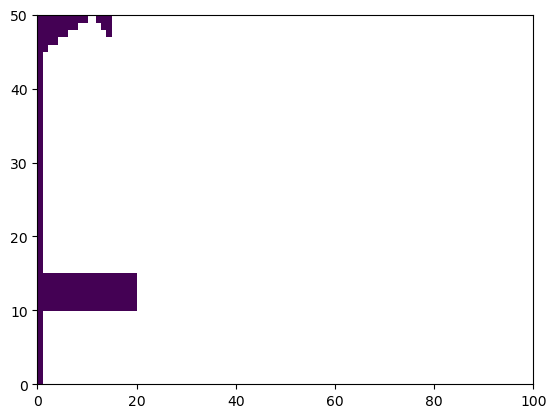

In [29]:
mask = xr.open_dataset("init_terranova.nc", group="/data")['mask']
land = np.where(mask == 0, 1, np.nan)
plt.pcolor(land)

In [2]:
%%bash

# Run the  model with the polynya config file
export OMP_NUM_THREADS=2
time /home/nextsimdg/build/nextsim --config-file config_files/config_polynya.cfg

2023-04-01T00:00:00Z
2023-04-01T00:01:00Z
2023-04-01T00:02:00Z
2023-04-01T00:03:00Z
2023-04-01T00:04:00Z
2023-04-01T00:05:00Z
2023-04-01T00:06:00Z
2023-04-01T00:07:00Z
2023-04-01T00:08:00Z
2023-04-01T00:09:00Z
2023-04-01T00:10:00Z
2023-04-01T00:11:00Z
2023-04-01T00:12:00Z
2023-04-01T00:13:00Z
2023-04-01T00:14:00Z
2023-04-01T00:15:00Z
2023-04-01T00:16:00Z
2023-04-01T00:17:00Z
2023-04-01T00:18:00Z
2023-04-01T00:19:00Z
2023-04-01T00:20:00Z
2023-04-01T00:21:00Z
2023-04-01T00:22:00Z
2023-04-01T00:23:00Z
2023-04-01T00:24:00Z
2023-04-01T00:25:00Z
2023-04-01T00:26:00Z
2023-04-01T00:27:00Z
2023-04-01T00:28:00Z
2023-04-01T00:29:00Z
2023-04-01T00:30:00Z
2023-04-01T00:31:00Z
2023-04-01T00:32:00Z
2023-04-01T00:33:00Z
2023-04-01T00:34:00Z
2023-04-01T00:35:00Z
2023-04-01T00:36:00Z
2023-04-01T00:37:00Z
2023-04-01T00:38:00Z
2023-04-01T00:39:00Z
2023-04-01T00:40:00Z
2023-04-01T00:41:00Z
2023-04-01T00:42:00Z
2023-04-01T00:43:00Z
2023-04-01T00:44:00Z
2023-04-01T00:45:00Z
2023-04-01T00:46:00Z
2023-04-01T00


real	8m33.433s
user	17m0.691s
sys	0m1.002s


In [3]:
# Load the NetCDF file

ds = xr.open_dataset("polynyaBBM_188C.diagnostic.nc", group="/data")
print(ds)

# We (still) need to fetch the mask from the init file

mask = xr.open_dataset("init_terranova.nc", group="/data")['mask']
land = np.where(mask == 0, 1, np.nan)  # 1 = land, nan = ocean
# Create sensible dates to use and a land mask
time = ds['time']
time_vals = num2date(time.values, units='seconds since 1970-01-01', calendar='gregorian')

time_index = 2

<xarray.Dataset>
Dimensions:         (time: 6, ydim: 50, xdim: 100, dg_comp: 6, yvertex: 51,
                     xvertex: 101, ncoords: 2, zdim: 3)
Coordinates:
  * time            (time) float64 1.68e+09 1.68e+09 ... 1.68e+09 1.68e+09
Dimensions without coordinates: ydim, xdim, dg_comp, yvertex, xvertex, ncoords,
                                zdim
Data variables: (12/58)
    C_ICE_DG        (time, ydim, xdim, dg_comp) float64 ...
    H_ICE_DG        (time, ydim, xdim, dg_comp) float64 ...
    OW_STRESS_X     (time, ydim, xdim) float64 ...
    OW_STRESS_Y     (time, ydim, xdim) float64 ...
    Q_SW_BASE       (time, ydim, xdim) float64 ...
    Q_SW_OW         (time, ydim, xdim) float64 ...
    ...              ...
    v               (time, ydim, xdim) float64 ...
    wind_speed      (time, ydim, xdim) float64 ...
    wind_u          (time, ydim, xdim) float64 ...
    wind_v          (time, ydim, xdim) float64 ...
    x               (time, ydim, xdim) float64 ...
    y             

In [4]:
# Striding for u and v
ny, nx = ds['u'].isel(time=0).shape
Y, X = np.meshgrid(np.arange(ny), np.arange(nx), indexing='ij')

stride = 5

u = ds['u'].isel(time=time_index)[::stride, ::stride]
v = ds['v'].isel(time=time_index)[::stride, ::stride]
x = X[::stride, ::stride]
y = Y[::stride, ::stride]

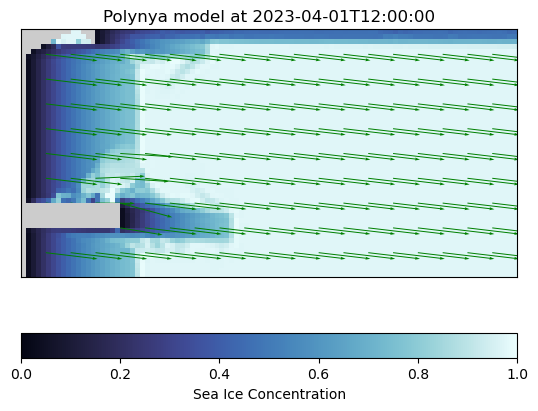

In [5]:
# NB - we need to pick the first DG component, as well as a time slice
var = ds['cice'].isel(time=time_index).isel(dg_comp=0)

plt.figure()
p = plt.pcolormesh(var, shading='auto', cmap='cmo.ice', vmin=0, vmax=1)
plt.gca().set_aspect('equal')

plt.colorbar(p, label='Sea Ice Concentration', orientation='horizontal')

plt.quiver(x, y, u, v, scale=5, color='g', width=0.002)

plt.pcolormesh(land, shading='auto', cmap='Pastel2', vmin=0, vmax=1)

plt.title(f"Polynya model at {time_vals[time_index].isoformat()}")

plt.xticks([])
plt.yticks([])
plt.show()
#plt.savefig('

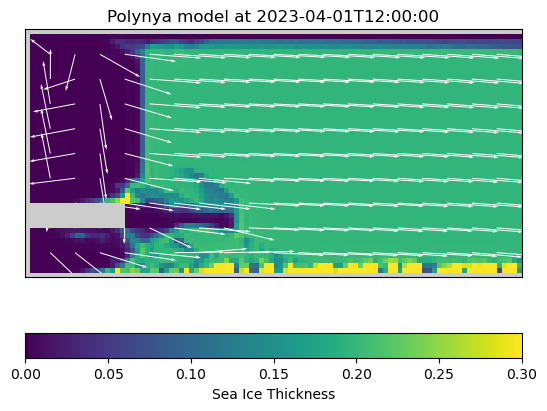

In [17]:
var = ds['hice'].isel(time=time_index).isel(dg_comp=0)

plt.figure()
p = plt.pcolormesh(var, shading='auto', cmap='viridis', vmin=0, vmax=0.3)
plt.gca().set_aspect('equal')

plt.colorbar(p, label='Sea Ice Thickness', orientation='horizontal')

plt.quiver(x, y, u, v, scale=5, color='w', width=0.002)

plt.pcolormesh(land, shading='auto', cmap='Pastel2', vmin=0, vmax=1)

plt.title(f"Polynya model at {time_vals[time_index].isoformat()}")

plt.xticks([])
plt.yticks([])
plt.show()

In [10]:
# NB - we need to pick the first DG component, as well as a time slice
var = ds['cice'].isel(time=time_index).isel(dg_comp=0)

plt.figure()
p = plt.pcolormesh(var, shading='auto', cmap='cmo.ice', vmin=0, vmax=1)
plt.gca().set_aspect('equal')

plt.colorbar(p, label='Sea Ice Concentration', orientation='horizontal')

plt.quiver(x, y, u, v, scale=5, color='g', width=0.002)

plt.pcolormesh(land, shading='auto', cmap='Pastel2', vmin=0, vmax=1)

plt.title(f"Polynya model at {time_vals[time_index].isoformat()}")

plt.xticks([])
plt.yticks([])
plt.show()